# model of claster

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn.cluster as cls
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir("D:\projectPy")

In [3]:
def clustDBSCAN(featureArr, params):
    clustering  = cls.DBSCAN(eps=params[0], min_samples=params[1]).fit(featureArr)

    core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
    core_samples_mask[clustering.core_sample_indices_] = True
    labels = clustering.labels_

    # кол-во кластеров, за исключением шумовой сост.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    # визуализация 
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # черный для шума
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = featureArr[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col),
                 markeredgecolor='k', markersize = 6)

        xy = featureArr[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col),
                 markeredgecolor='k', markersize = 3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

In [4]:
workData = pd.read_csv('C001_040_080.csv', names = ['Time', 'Lg_Time2TimeMax',
                                                    'RCS', 'Lg_Rcs2RcsMax'], sep = ';', decimal=',')
workData.astype(np.float64)
workData.head()

,Time,Lg_Time2TimeMax,RCS,Lg_Rcs2RcsMax
0,10.8,-7.01,0.02,-28.20
1,21.1,-4.11,0.00,-46.72
2,21.0,-4.13,0.00,-40.10
3,20.7,-4.19,0.00,-40.30
4,20.4,-4.25,0.00,-46.72


In [5]:
a = np.array([workData['Time'].values])
b = np.array([workData['Lg_Rcs2RcsMax'].values])
featureArr = np.vstack((a, b)).T

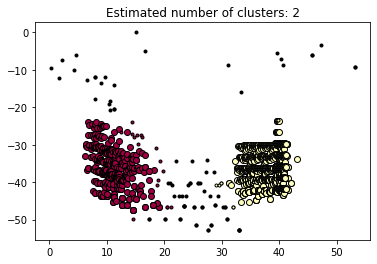

In [6]:
params = np.array([3, 11])
labels = clustDBSCAN(featureArr, params)

## 2 part DBSCAN

In [7]:
workData['labels_1'] = labels
a2 = np.array([workData['Time'].values[workData['labels_1'] == -1]])
b2 = np.array([workData['Lg_Rcs2RcsMax'].values[workData['labels_1'] == -1]])
featureArr2 = np.vstack((a2, b2)).T

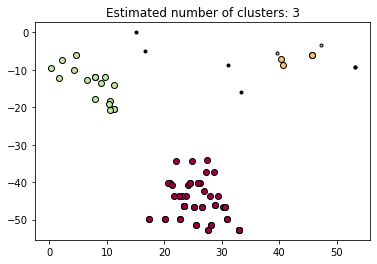

In [8]:
paramsDisc = np.array([6, 4])
labelsDisc = clustDBSCAN(featureArr2, paramsDisc)

In [9]:
workData['labels_2'] = workData['labels_1']
nClusters = len(set(labels)) - (1 if -1 in labels else 0)
labelsDisc[labelsDisc != -1] = labelsDisc[labelsDisc != -1]  + nClusters
workData['labels_2'].values[workData['labels_1'] == -1] = labelsDisc

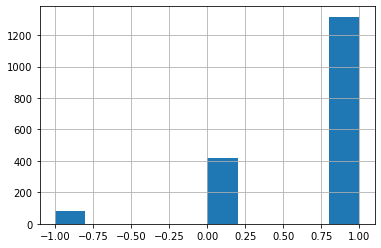

In [10]:
workData['labels_1'].hist()


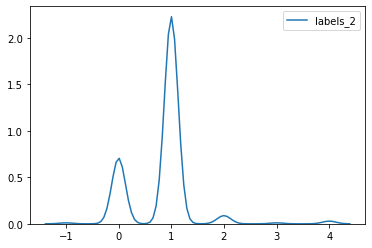

In [11]:
sns.kdeplot(workData['labels_2'])


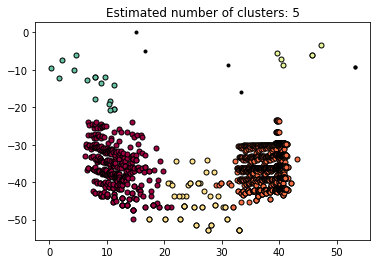

In [12]:
coreSamplesMask = np.zeros_like(workData['labels_2'], dtype=bool)
coreSamplesMask[workData['labels_2'].values != -1] = True
labelsFinal = workData['labels_2'].values

# кол-во кластеров, за исключением шумовой сост.
nClusters = len(set(labelsFinal)) - (1 if -1 in labelsFinal else 0)
    
# визуализация 
uniqueLabels = set(labelsFinal)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(uniqueLabels))]

for k, col in zip(uniqueLabels, colors):
    if k == -1:
        # черный для шума
        col = [0, 0, 0, 1]

    classMemberMmask = (labelsFinal == k)

    xy = featureArr[classMemberMmask & coreSamplesMask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col),
        markeredgecolor='k', markersize = 5)

    xy = featureArr[classMemberMmask & ~coreSamplesMask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor = tuple(col),
        markeredgecolor='k', markersize = 3)

plt.title('Estimated number of clusters: %d' % nClusters)
plt.show()

Полигауссовская модель импульсной ЭПР

In [13]:
Data4EM = workData.sort_values(by = 'labels_2')

In [14]:
Data4EM.head()

,Time,Lg_Time2TimeMax,RCS,Lg_Rcs2RcsMax,labels_1,labels_2
1793,33.3,-2.12,0.37,-15.85,-1,-1
1798,15.1,-5.56,14.11,0.00,-1,-1
1797,16.7,-5.12,4.53,-4.94,-1,-1
1787,53.2,-0.09,1.70,-9.19,-1,-1
1796,53.2,-0.09,1.70,-9.19,-1,-1


In [15]:
import math
def Gaus(Tg):
    Scal = math.log(10.0)
    Gaus = math.exp(0 - ((Tg)**2) * Scal )
    return Gaus

In [16]:
RcsImp = dict()
TimImp = dict()

for ii in range(Data4EM.labels_2.min(), Data4EM.labels_2.max() + 1):
    LabelData = Data4EM[Data4EM.labels_2 == ii].loc[:, ['Time', 'RCS']]
    Nsa = LabelData.shape[0]
    Tau = 0.5
    Trcs = 2 * Tau + LabelData.Time.iloc[-1]
    dTim = 0.05
    Mcs = 1 + int(Trcs / dTim)
    Tim = 0.0
    
    TimeList = list()
    for j in range(Mcs):
        TimeList.append(Tim)
        Tim = Tim + dTim
        
    Rcs = np.zeros(Mcs)
    RcsList = list()
    for i in range(Nsa):
        Tim = LabelData.Time.iloc[i]
        Rcsf = LabelData.RCS.iloc[i]
        Jmin = 1 + int((Tim - Tau) / dTim)
        Jmax = 1 + int((Tim + Tau) / dTim)
        if Jmin < 1: Jmin = 1
        if Jmax > Mcs: Jmax = Mcs
        for j in range(Jmin, Jmax):
            Tgs = (TimeList[j] - Tim) / Tau
            Rcs[j] = Rcs[j] + Rcsf * Gaus(Tgs)

    for j in range(Mcs):
        RcsList.append(Rcs[j])
        
    NumberCls = str(ii)
    RcsImp.update({NumberCls : RcsList}) 
    TimImp.update({NumberCls : TimeList}) 

In [17]:
DataImp_Cls = pd.DataFrame.from_dict(RcsImp, orient='index').transpose()
TimImp_Cls = pd.DataFrame.from_dict(TimImp, orient='index').transpose()

In [18]:
TimImp_Cls.tail()

,-1,0,1,2,3,4
810,NaN,NaN,NaN,NaN,40.50,NaN
811,NaN,NaN,NaN,NaN,40.55,NaN
812,NaN,NaN,NaN,NaN,40.60,NaN
813,NaN,NaN,NaN,NaN,40.65,NaN
814,NaN,NaN,NaN,NaN,40.70,NaN


In [19]:
DataImp_Cls['Tim'] = TimImp_Cls.loc[:, '3']
DataImp_Cls.columns = ['Noise', 'Cls0', 'Cls1', 'Cls2', 'Cls3', 'Cls4', 'Tim']

DataImp_Cls.fillna(0, inplace=True)
DataImp_Cls.head()

,Noise,Cls0,Cls1,Cls2,Cls3,Cls4,Tim
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00
1,0.0,0.0,0.0,0.0,0.0,1.276144,0.05
2,0.0,0.0,0.0,0.0,0.0,1.431857,0.10
3,0.0,0.0,0.0,0.0,0.0,1.534262,0.15
4,0.0,0.0,0.0,0.0,0.0,1.570000,0.20


Text(0.5, 0, 'Tim')

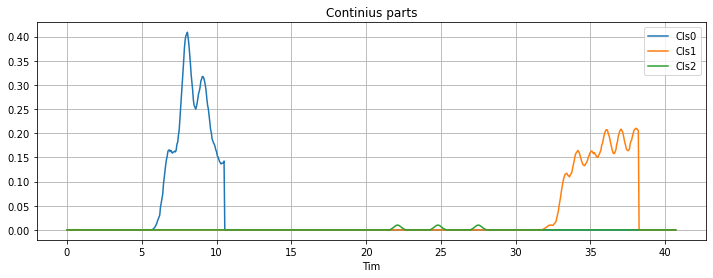

In [20]:
plt.figure(figsize=(12, 4))

plt.title("Continius parts")

plt.plot(DataImp_Cls['Tim'], DataImp_Cls['Cls0'])
plt.plot(DataImp_Cls['Tim'], DataImp_Cls['Cls1'])
plt.plot(DataImp_Cls['Tim'], DataImp_Cls['Cls2'])

plt.legend(('Cls0', 'Cls1', 'Cls2'),  loc='upper right')
plt.grid()
plt.xlabel("Tim")

Text(0.5, 0, 'Tim')

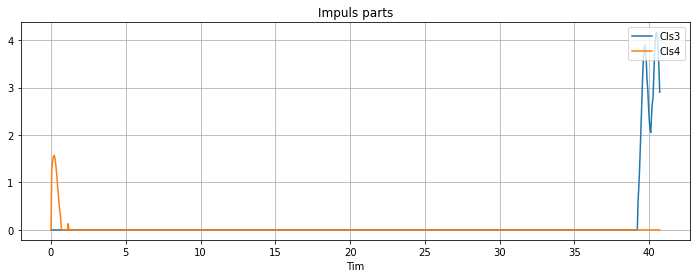

In [21]:
plt.figure(figsize=(12, 4))

plt.title("Impuls parts")

plt.plot(DataImp_Cls['Tim'], DataImp_Cls['Cls3'], label="Cls3")
plt.plot(DataImp_Cls['Tim'], DataImp_Cls['Cls4'], label="Cls4")

plt.legend(('Cls3', 'Cls4'),  loc='upper right')
plt.grid()
plt.xlabel("Tim")

In [22]:
DataImp_Cls['Continius_Part'] = DataImp_Cls['Cls0'].values + DataImp_Cls['Cls1'].values \
            + DataImp_Cls['Cls2'].values
DataImp_Cls.head()

,Noise,Cls0,Cls1,Cls2,Cls3,Cls4,Tim,Continius_Part
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0
1,0.0,0.0,0.0,0.0,0.0,1.276144,0.05,0.0
2,0.0,0.0,0.0,0.0,0.0,1.431857,0.10,0.0
3,0.0,0.0,0.0,0.0,0.0,1.534262,0.15,0.0
4,0.0,0.0,0.0,0.0,0.0,1.570000,0.20,0.0


In [23]:
DataImp_Cls['Impuls_Part'] = DataImp_Cls['Cls3'].values + DataImp_Cls['Cls4'].values
DataImp_Cls.head()

,Noise,Cls0,Cls1,Cls2,Cls3,Cls4,Tim,Continius_Part,Impuls_Part
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,1.276144,0.05,0.0,1.276144
2,0.0,0.0,0.0,0.0,0.0,1.431857,0.10,0.0,1.431857
3,0.0,0.0,0.0,0.0,0.0,1.534262,0.15,0.0,1.534262
4,0.0,0.0,0.0,0.0,0.0,1.570000,0.20,0.0,1.570000
